# Test of different sparsity objectives 
The plan is to test how different sparsity measures applied affect some toy vectors.

1. Test sparcity measures with a training objective to plot a digit 3 on a 7x7 grid.

2. Test sparcity measures with a hidden vector in a simple autoencoder.

# 1. Digit objective

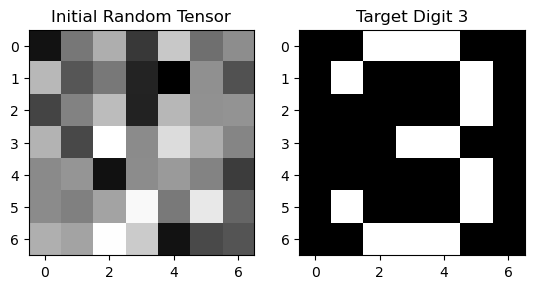

In [15]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# define the tensor for optimization and the target digit
x = torch.randn(49, requires_grad=True)
target_digit = torch.tensor([
    0, 0, 1, 1, 1, 0, 0,
    0, 1, 0, 0, 0, 1, 0,
    0, 0, 0, 0, 0, 1, 0,
    0, 0, 0, 1, 1, 0, 0,
    0, 0, 0, 0, 0, 1, 0,
    0, 1, 0, 0, 0, 1, 0,
    0, 0, 1, 1, 1, 0, 0
], dtype=torch.float32)

# plot the target digit and the initial random tensor
plt.subplot(1, 2, 1)
plt.imshow(x.detach().numpy().reshape(7, 7), cmap='gray')
plt.title("Initial Random Tensor")
plt.subplot(1, 2, 2)
plt.imshow(target_digit.reshape(7, 7).detach().numpy(), cmap='gray')
plt.title("Target Digit 3")
plt.show()

In [32]:
# different sparsity objectives

from torch.nn import functional as F
def l1_sparsity(tensor):
    return torch.sum(torch.abs(tensor))

def l2_sparsity(tensor):
    return torch.sum(tensor ** 2)

def hoyer_sparsity(tensor, eps: float = 1e-12):
    n = tensor.numel()
    sqrt_n = torch.sqrt(torch.tensor(float(n), device=tensor.device))
    l1 = tensor.abs().sum()
    l2 = torch.linalg.vector_norm(tensor, ord=2).clamp_min(eps)

    numerator = sqrt_n - l1 / l2
    denominator = sqrt_n - 1
    mod_hoyer = 1 - (numerator / denominator) # = 0 if perfectly sparse, 1 if all are equal

    return mod_hoyer

def v_vT_sparsity(tensor):
    v = tensor.view(-1, 1)
    v_vT = torch.matmul(v, v.t())
    return torch.sum(torch.abs(v_vT))

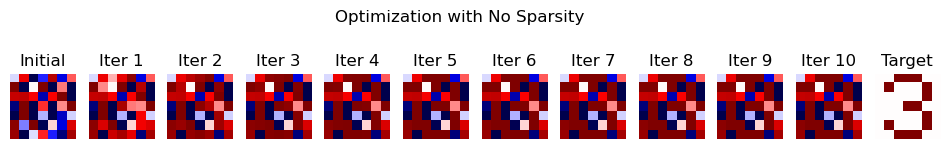

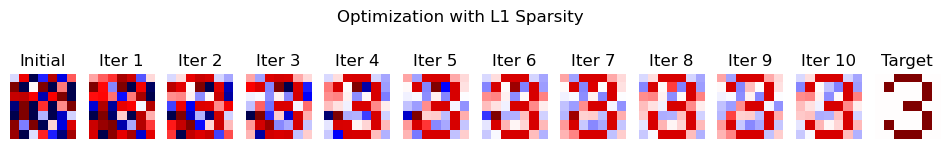

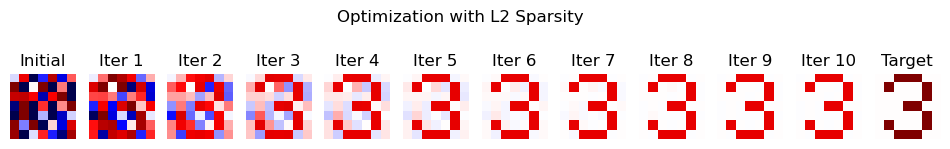

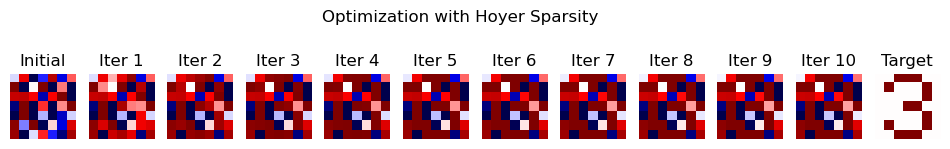

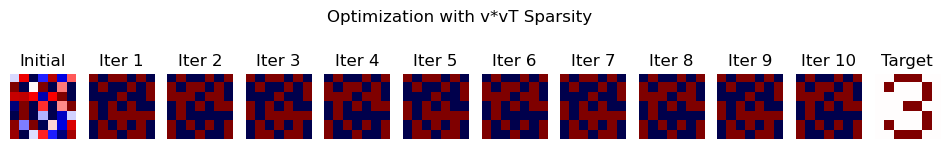

In [62]:
# optimize tensor to match target (MSE loss masked by target digit)
def optimize_with_sparsity(x, target, sparsity_fn, sparsity_weight=0.1, learning_rate=0.1, num_iterations=10):

    x_copy = x.detach().clone().requires_grad_(True)
    optimizer = torch.optim.SGD([x_copy], lr=learning_rate)
    history = [x_copy.detach().clone()]

    for _ in range(num_iterations):
        optimizer.zero_grad()

        mask_idx = (target > 0)
        x_masked = x_copy[mask_idx]
        target_masked = target[mask_idx]
        loss = F.mse_loss(x_masked, target_masked) + sparsity_weight * sparsity_fn(x_copy)
        loss.backward()
        optimizer.step()

        history.append(x_copy.detach().clone())
    return x_copy, history

sparsity_functions = {
    "No Sparsity": lambda x: 0,
    "L1 Sparsity": l1_sparsity,
    "L2 Sparsity": l2_sparsity,
    "Hoyer Sparsity": hoyer_sparsity,
    "v*vT Sparsity": v_vT_sparsity
}   

# run optimization for each sparsity function and plot results
num_iterations = 10
x = torch.randn(49, requires_grad=True)
for name, sparsity_fn in sparsity_functions.items():
    optimized_x, history = optimize_with_sparsity(x, target_digit, sparsity_fn, sparsity_weight=0.05, learning_rate=5, num_iterations=num_iterations)

    plt.figure(figsize=(12, 2))
    for i, h in enumerate(history):
        plt.subplot(1, num_iterations + 2, i + 1)
        plt.imshow(h.numpy().reshape(7, 7), cmap='seismic', vmin=-1, vmax=1)
        plt.title(f"Iter {i}" if i != 0 else "Initial")
        plt.axis('off')
    plt.subplot(1, num_iterations + 2, i + 2)
    plt.imshow(target_digit.numpy().reshape(7, 7), cmap='seismic', vmin=-1, vmax=1)
    plt.title("Target")
    plt.axis('off')

    plt.suptitle(f"Optimization with {name}")
    plt.show()